# **Estudios con Taxi**

_Esto es un ejemplo de uso de Gymnasium e informe sobre un experimento de aprendizaje por refuerzo_

````
José María García, Ana Gil, Levi Malest
````

Este notebook describe varios experimentos de aprendizaje por refuerzo utilizando el algoritmo de Monte Carlo con políticas epsilon-soft, tanto on-policy como off-policy, así como el algoritmo SARSA y el Q-learning. El propósito de este análisis es entrenar un agente en un entorno de gym con el juego "Taxi", un entorno estándar en el que el agente debe aprender a moverse a través de un mapa recogiendo a pasajeros y llevándolos a otra localización. A continuación, se presenta una descripción de las diferentes partes del código y el proceso utilizado en el experimento.

## **1. Preparación del Entorno**

La preparación consta de las siguientes partes:
- **Instalación de Dependencias**: Se instalan las librerías necesarias para utilizar el entorno `gymnasium` para la simulación, con el objetivo de crear un ambiente controlado para que el agente pueda interactuar.
- **Importación de Librerías**: Se importan las bibliotecas necesarias como `numpy` para el manejo de matrices y `matplotlib` para la visualización de los resultados.

- **Importación del Entorno "Taxi"**:
Se carga una versión del entorno "Taxi", recoger a pasajeros y dejarlos en una de 4 localizaciones. Las acciones serán:

 - 0: Move south (down)

 - 1: Move north (up)

 - 2: Move east (right)

 - 3: Move west (left)

 - 4: Pickup passenger

 - 5: Drop off passenger

 Las recompensas predeterminadas son las siguientes:

 - Recompensa al dejar al pasajero en el destino correcto: +20

 - Recompensa por pasos normales: -1

 - Recompensa por recoger o dejar al pasajero en un lugar incorrecto: -10 (penalización por acción incorrecta)

#### 3. **Funciones para Mostrar los Resultados**
   - Se define una función para graficar la proporción de recompensas obtenidas en cada episodio del entrenamiento. Esto ayuda a visualizar el progreso del agente en términos de su desempeño durante el entrenamiento.



##### _________ **Código de la Instalación e Importación**
----

In [1]:
%%capture
#@title Instalamos gym
!pip install 'gym[box2d]==0.20.0'

## Instalación de algunos paquetes.
#!apt-get update
## Para usar gymnasium[box2d]
#!apt install swig
#!pip install gymnasium[box2d]

In [2]:
#@title Importamos librerias
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
from gymnasium.wrappers import TimeLimit

In [23]:
#@title Importamos el entorno
name = 'Taxi-v3'
env = gym.make(name, render_mode="ansi")

In [7]:
#@title Copiar el repositorio ``JMGO-coding/RL_GGM``.

!git clone https://github.com/JMGO-coding/RL_GGM.git
!cd RL_GGM/

Cloning into 'RL_GGM'...
remote: Enumerating objects: 832, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 832 (delta 111), reused 7 (delta 7), pack-reused 667 (from 1)
Receiving objects: 100% (832/832), 4.98 MiB | 20.99 MiB/s, done.
Resolving deltas: 100% (482/482), done.


In [8]:
#@title Importamos todas las clases y funciones

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/RL_GGM')
sys.path.append('/content/RL_GGM/src')

# Verificar que se han añadido correctamente
print(sys.path)

from agents import Agent, AgentMCOnPolicyAllVisits, AgentMCOffPolicyAllVisits, AgentSARSA, AgentQLearning
from policies import EpsilonSoftPolicy, GreedyFromQPolicy
from wrappers import CliffWalkingCustomRewards

['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/content/RL_GGM', '/content/RL_GGM/src']


In [21]:
import os
import gc
import torch
import numpy as np
import gymnasium as gym

# Configuración del dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Liberación de memoria para evitar problemas de consumo en GPU
gc.collect() # Ejecuta el recolector de basura de Python
torch.cuda.empty_cache() # Vacía la caché de memoria en GPU

# Depuración de errores en CUDA
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # Muestra errores de CUDA en el punto exacto donde ocurren

# Configuración de la semilla para reproducibilidad
seed = 2024 # Se define una semilla fija

# Fijar la semilla en NumPy
np.random.seed(seed) # Para generar números aleatorios consistentes en NumPy
np.random.default_rng(seed) # Establece una instancia del generador de NumPy con la misma semilla

# Fijar la semilla en Python
os.environ['PYTHONHASHSEED'] = str(seed) # Evita variabilidad en hashing de Python

# Fijar la semilla en PyTorch
torch.manual_seed(seed) # Asegura resultados reproducibles en operaciones de PyTorch

if torch.cuda.is_available(): # Si hay GPU disponible
    torch.cuda.manual_seed(seed) # Fija la semilla para la GPU
    torch.backends.cudnn.deterministic = True # Hace las operaciones de CUDNN determinísticas
    torch.backends.cudnn.benchmark = False # Desactiva optimizaciones de CUDNN para evitar variabilidad

# Fijar la semilla en Gymnasium
def make_env(env_name):
    env = gym.make(env_name)
    env.reset(seed=seed) # Establece la semilla en el entorno de Gymnasium
    return env

# Ejemplo de creación de un entorno con semilla
env.reset(seed=seed)

Usando dispositivo: cpu


(36, {'prob': 1})

## **2. Diseño del Agente**

El diseño del agente consta de dos partes, el algoritmo con el que aprende y las políticas (toma de decisiones) que realiza.

- **Políticas del Agente**
   - **Política epsilon-soft**: Se define una política donde todas las acciones tienen una probabilidad de ser elegida.
   - **Política epsilon-greedy**: basada en la política epsilon-soft. De esta forma el agente tiene una pequeña probabilidad de explorar (tomar una acción aleatoria) y una mayor probabilidad de explotar (tomar la acción que considera mejor). Esto permite equilibrar la exploración y la explotación.
   - **Política greedy**: Es la usada una vez que "ha aprendido".

- **Algoritmo de Iteración de Valor**
  - Se implementa el algoritmo de iteración de valor utilizando Monte Carlo.
  - Se usa una versión "on-policy" de Monte Carlo con políticas epsilon greedy sobre una política epsilon-soft.
  - Se basa en el criterio de todas las visitas.
  - Otro aspecto es que la actualización de los retornos no se realiza en el orden inverso a las visitas.

#### **Código de las políticas y algoritmo MC**
----------------

Nota: Aunque las siguientes funciones no se utilizan en la implementación final, las dejamos aquí como referencia, ya que representan la lógica interna que ahora está encapsulada dentro de la clase del agente. Solo mostramos estas funciones para el algoritmo Monte Carlo on-policy como ejemplo. Con el resto de algoritmos pasaremos directamente a usar los agentes desde GitHub.

In [ ]:
# @title Políticas del agente

# actions
LEFT, DOWN, RIGHT, UP = 0,1,2,3

# Política epsilon-soft. Se usa para el entrenamiento
def random_epsilon_greedy_policy(Q, epsilon, state, nA):
    pi_A = np.ones(nA, dtype=float) * epsilon / nA
    best_action = np.argmax(Q[state])
    pi_A[best_action] += (1.0 - epsilon)
    return pi_A

# Política epsilon-greedy a partir de una epsilon-soft
def epsilon_greedy_policy(Q, epsilon, state, nA):
    pi_A = random_epsilon_greedy_policy(Q, epsilon, state, nA)
    return np.random.choice(np.arange(nA), p=pi_A)

# Política Greedy a partir de los valores Q. Se usa para mostrar la solución.
def pi_star_from_Q(env, Q):
    done = False
    pi_star = np.zeros([env.observation_space.n, env.action_space.n])
    state, info = env.reset() # start in top-left, = 0
    actions = ""
    while not done:
        action = np.argmax(Q[state, :])
        actions += f"{action}, "
        pi_star[state,action] = 1
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    return pi_star, actions

In [ ]:
#@title Algoritmo de Iteración de Valor versión MC con Políticas epsilon-soft

def on_policy_all_visit(env, num_episodes=5000, epsilon=0.4, decay=False, discount_factor=1):
    # Matriz de valores Q
    nA = env.action_space.n
    Q = np.zeros([env.observation_space.n, nA])

    # Número de visitas y acumulación de retornos
    n_visits = np.zeros([env.observation_space.n, env.action_space.n])
    returns = np.zeros([env.observation_space.n, env.action_space.n])

    # Para mostrar la evolución en el terminal
    stats = 0.0
    list_stats = [stats]
    step_display = num_episodes / 10

    # Para cada episodio
    for t in tqdm(range(num_episodes)):
        state, info = env.reset(seed=100)
        done = False
        episode = []

        # Generar un episodio siguiendo la política epsilon-soft
        while not done:
            if decay:
                epsilon = min(1.0, 1000.0/(t+1))
            action = epsilon_greedy_policy(Q, epsilon, state, nA)
            new_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode.append((state, action, reward))  # Almacenar estado, acción y recompensa
            state = new_state

        G = 0.0  # Retorno
        # Recorrer el episodio en orden inverso
        for (state, action, reward) in reversed(episode):
            G = discount_factor * G + reward
            n_visits[state, action] += 1  # Contamos cuántas veces hemos visitado (state, action)
            returns[state, action] += G  # Acumulamos los retornos

            # Usamos el promedio de los retornos observados
            Q[state, action] = returns[state, action] / n_visits[state, action]

        # Guardamos datos sobre la evolución
        stats += G
        list_stats.append(stats/(t+1))

        # Para mostrar la evolución. Comentar si no se quiere mostrar
        if t % step_display == 0 and t != 0:
            print(f"success: {stats/t}, epsilon: {epsilon}")

    return Q, list_stats

## **3. Preparación del entorno para grabar episodios de Gymnasium**

### Instalación de paquetes

In [10]:
# Instalación de algunos paquetes.
!apt-get update

# Para visualizar en colab https://medium.com/@coldstart_coder/visually-rendering-python-gymnasium-in-jupyter-notebooks-4413e4087a0f
!apt-get install -y python-opengl ffmpeg
!apt-get install --upgrade cmake

# Para usar gymnasium[box2d]
!apt install swig xvfb
!pip install -U  pyvirtualdisplay

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,369 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,731 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [56.4 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3,774 kB]
Hit:13 https://ppa.launchp

In [11]:
!pip install gymnasium gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.2 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2351176 sha256=e37bca8c46185c4e49c8b10c7e72768f1c249221ba12f26b375991e24fcd0283
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


### Creando pantallas virtuales

In [12]:
## Para visualizar en colab https://medium.com/@coldstart_coder/visually-rendering-python-gymnasium-in-jupyter-notebooks-4413e4087a0f
## https://medium.com/@coldstart_coder/dqn-algorithm-training-an-ai-to-land-on-the-moon-1a1307748ed9
# create a virtual display that will hold our video

# Google Colab se ejecuta en un entorno de servidor sin una interfaz gráfica de
# usuario (GUI). Para mostrar contenido visual como videos, se necesita una
# pantalla virtual para simular una pantalla.
# Esto permite que bibliotecas como gymnasium rendericen gráficos
# y los capturen para incrustarlos en el notebook.
#
# Este código crea una pantalla virtual oculta donde se puede renderizar contenido gráfico.

# pyvirtualdisplay es una biblioteca se usa para crear pantallas virtuales,
# que son esenciales para renderizar contenido gráfico en entornos sin interfaz gráfica.
from pyvirtualdisplay import Display

# visible=0 indica que la pantalla estará oculta (no visible para el usuario).
# Esto se debe a que Colab se ejecuta en un entorno de servidor sin una interfaz gráfica.
# size=(1400, 900) establece la resolución de la pantalla virtual a 1400x900 píxeles.
display = Display(visible=0, size=(1400, 900))

# inicia la pantalla virtual, preparándola para su uso.
display.start()


# Las siguientes líneas importan las bibliotecas necesarias para trabajar
# con entrada/salida, codificación base64 (usada para incrustar datos de video)
# y mostrar contenido HTML dentro del notebook de Colab.
import io
import base64
from IPython import display
from IPython.display import HTML

# Esta función mostrará un vídelo en la pantalla virtual, que será embembida en el notbook
def embed_video(video_file):
    # open and read the raw data from the video
    video_data = io.open(video_file, 'r+b').read()
    # now we have to encode the data into base64 to work
    # with the virtual display
    encoded_data = base64.b64encode(video_data)
    # now we use the display.display function to take some html
    # and the encoded data and embed the html into the notebook!
    display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded_data.decode('ascii'))))

### Para crear y mostrar  los vídeos generados

In [13]:
import re # Para trabajar con expresiones regulares
import os # Para manipular archivos, directorios, variables de entorno y ejecutar comandos del SO

# Define la carpeta donde se guardarán los vídeos
video_folder = "videos"  # Nombre de la carpeta (puedes cambiarlo)

# Crea la carpeta si no existe
os.makedirs(video_folder, exist_ok=True) # exist_ok=True evita error si ya existe

# Retorna el nombre del último vídeo generado

def get_latest_episode_video_file(directory):
    # Expresión regular que coincide con el formato de los ficheros de video
    pattern = re.compile(r"rl-video-episode-(\d+)\.mp4")
    latest_file = None
    highest_episode = -1

    # Busca en el directorio
    for filename in os.listdir(directory):
        match = pattern.match(filename)
        if match:
            episode_number = int(match.group(1))  # Extrae el número de episodio
            # Comprobamos, para conseguir el número de episodio más alto.
            if episode_number > highest_episode:
                highest_episode = episode_number
                latest_file = os.path.join(directory, filename)  # Almacena el path completo

    return latest_file

### **Representaciones Gráficas**

Para comprobar el aprendizaje se mostrará la función $f(t)=\frac{\sum_{i=1}^t R_i}{t}$ para $t=1,2,\ldots, NumeroEpisodios$. La justificación es la siguiente. Como sabemmos que el retorno en el estados inicial 1 (pues no hay descuento) o 9, si se divide por el número de episodios ejecutados se calcular el porcentaje de recompensas positivas obtenidas. Dicho de otra forma, nos dirá el porcentaje de veces que el agente ha llegado al estado terminal.

También se muestra una gráfica con la longitud de los episodios en cada estado. Esta gráfica nos será útil para analizar si realmente el algoritmo está aprendiendo a llegar a la meta en cada episodio, observando cómo evoluciona la duración de los episodios a lo largo del entrenamiento (lo ideal sería que vayan disminuyendo conforme vaya aprendiendo).

In [14]:
# @title Funciones para mostrar los resultados

def plot(list_stats):
  # Creamos una lista de índices para el eje x
  indices = list(range(len(list_stats)))

  # Creamos el gráfico
  plt.figure(figsize=(15, 8))
  plt.plot(indices, list_stats)

  # Añadimos título y etiquetas
  plt.title('Proporción de recompensas')
  plt.xlabel('Episodio')
  plt.ylabel('Proporción')

  # Mostramos el gráfico
  plt.grid(True)
  plt.show()

# Función para mostrar el tamaño de los episodios
def plot_episode_lengths(episode_lengths):
    """
    Grafica la longitud de los episodios
    """
    # Creamos una lista de índices para el eje x (número de episodios)
    indices = list(range(len(episode_lengths)))

    # Creamos el gráfico
    plt.figure(figsize=(15, 8))
    plt.plot(indices, episode_lengths)

    # Añadimos título y etiquetas
    plt.title('Longitud de los Episodios')
    plt.xlabel('Episodio')
    plt.ylabel('Longitud del Episodio')

    # Mostramos el gráfico
    plt.grid(True)
    plt.show()

# Histograma con la longitud de los episodios
def plot_episode_lengths_histogram(episode_lengths, bins=20):
    """
    Muestra un histograma de la frecuencia de las longitudes de episodios
    """
    plt.figure(figsize=(15, 8))
    plt.hist(episode_lengths, bins=bins, alpha=0.75, color='blue', edgecolor='black')

    plt.title('Distribución de la Longitud de los Episodios')
    plt.xlabel('Longitud del Episodio')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

## **4. Monte Carlo on-policy**

   - En esta sección, el algoritmo de Monte Carlo on-policy con la política epsilon-soft se ejecuta para el entorno Cliff Walking.
   
   - Se realiza un entrenamiento con un número determinado de episodios (50000 en concreto).

   - Además el epsilon tiene decaimiento de acuerdo a la expresión: $\epsilon = min(1.0, 1000.0/(t+1))$

   - Durante el entrenamiento hay una visualización de la proporción de recompensas obtenidas a lo largo del entrenamiento.

   - Junto a dicho volcado se muestra gráficamente la proporcion de recompensas obtendias.

   - También se hace un volcado de los valores Q de cada estado, donde se muestra cómo el agente valora diferentes acciones en distintos estados del entorno, lo que puede interpretarse como su conocimiento sobre las mejores estrategias para alcanzar la meta sin caer en los agujeros.

   - Además, se muestra la política óptima derivada de los valores Q. Esta política es la que el agente seguiría si tuviera que elegir siempre la acción que maximiza su recompensa esperada.

   

In [28]:
#@title **Modificación del límite de pasos**

env._max_episode_steps = 500  # Cambiar el límite de pasos



  - Se realizan 50000 episodios y se actualizan los valores Q (valor de acción) basándose en las recompensas obtenidas durante cada episodio completo (e.d. aplicamos Monte Carlo) Se apica una política $\epsilon$ greedy sobre una política $\epsilon$ soft con un valor $\epsilon$ decreciente



In [29]:
# @title Aprendizaje
agent = AgentMCOnPolicyAllVisits(env, epsilon=0.4, decay=True, discount_factor=1)
agent.train(num_episodes=50000)

# Estadísticos
list_stats, episode_lengths = agent.get_stats()

 10%|█         | 5017/50000 [01:00<09:08, 82.03it/s]

success: -822.116, epsilon: 0.19996000799840033


 20%|██        | 10027/50000 [01:52<05:50, 114.17it/s]

success: -621.4174, epsilon: 0.0999900009999


 30%|███       | 15016/50000 [02:57<06:12, 94.02it/s]

success: -547.648, epsilon: 0.06666222251849876


 40%|████      | 20013/50000 [04:00<06:17, 79.36it/s]

success: -493.27585, epsilon: 0.04999750012499375


 50%|█████     | 25011/50000 [04:56<04:29, 92.87it/s]

success: -454.04468, epsilon: 0.03999840006399744


 60%|██████    | 30007/50000 [05:57<03:55, 84.89it/s]

success: -427.95466666666664, epsilon: 0.033332222259258026


 70%|███████   | 35014/50000 [06:53<03:30, 71.13it/s]

success: -401.3402, epsilon: 0.02857061226822091


 80%|████████  | 40012/50000 [07:44<01:49, 90.80it/s]

success: -379.404975, epsilon: 0.02499937501562461


 90%|█████████ | 45013/50000 [08:35<00:52, 94.40it/s]

success: -359.12815555555557, epsilon: 0.02222172840603542


100%|██████████| 50000/50000 [09:22<00:00, 88.89it/s] 


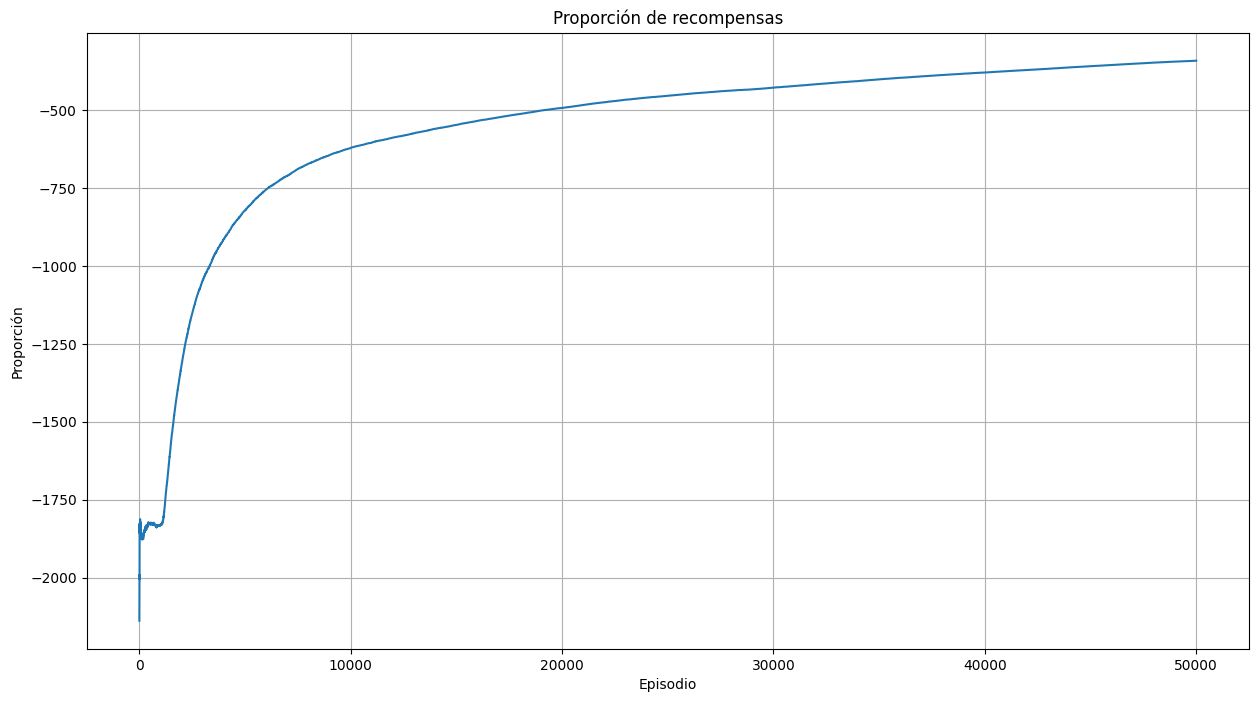

Máxima proporcion: -341.66064


In [30]:
#@title Proporción de aciertos por número de episodios

plot(list_stats)
print(f"Máxima proporcion: {list_stats[-1]}")

La proporción de recompensas va aumentando a lo largo de los episodios hasta alcanzar una máxima proporción de cerca de -340 de recompensa. Esto puede ser debido a que, a medida que el agente avanza por el entorno, las penalizaciones por cada acción (de -1) se acumulan, y si el agente no tiene una política eficaz, podría estar realizando muchos movimientos innecesarios. Esto provocaría que el agente acumule una gran cantidad de penalizaciones antes de llegar a la meta. Sin embargo, vemos como a lo largo de los episodios la política va mejorando relativamente.

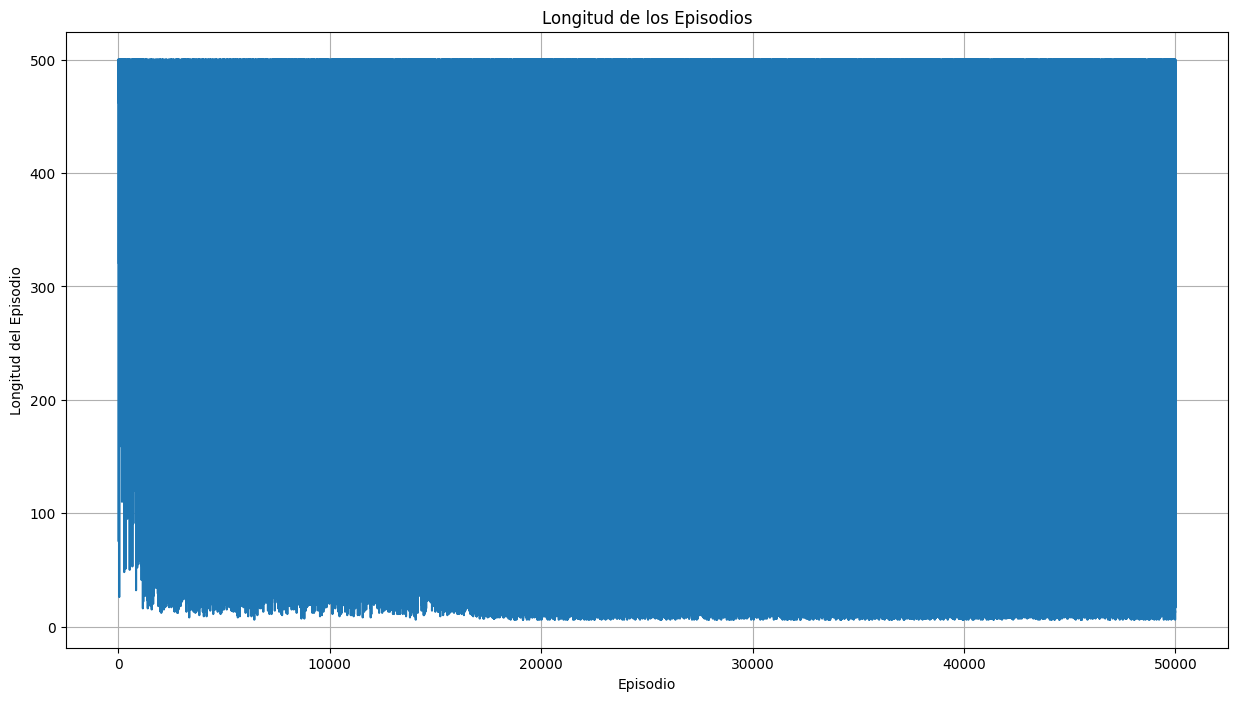

In [31]:
#@title Longitud de los episodios

plot_episode_lengths(episode_lengths)

Con el paso de los episodios, la longitud de los mismos no consigue disminuir, pues se alcanza el máximo permitido en muchos de los episodios sin llegar a un estado terminal.

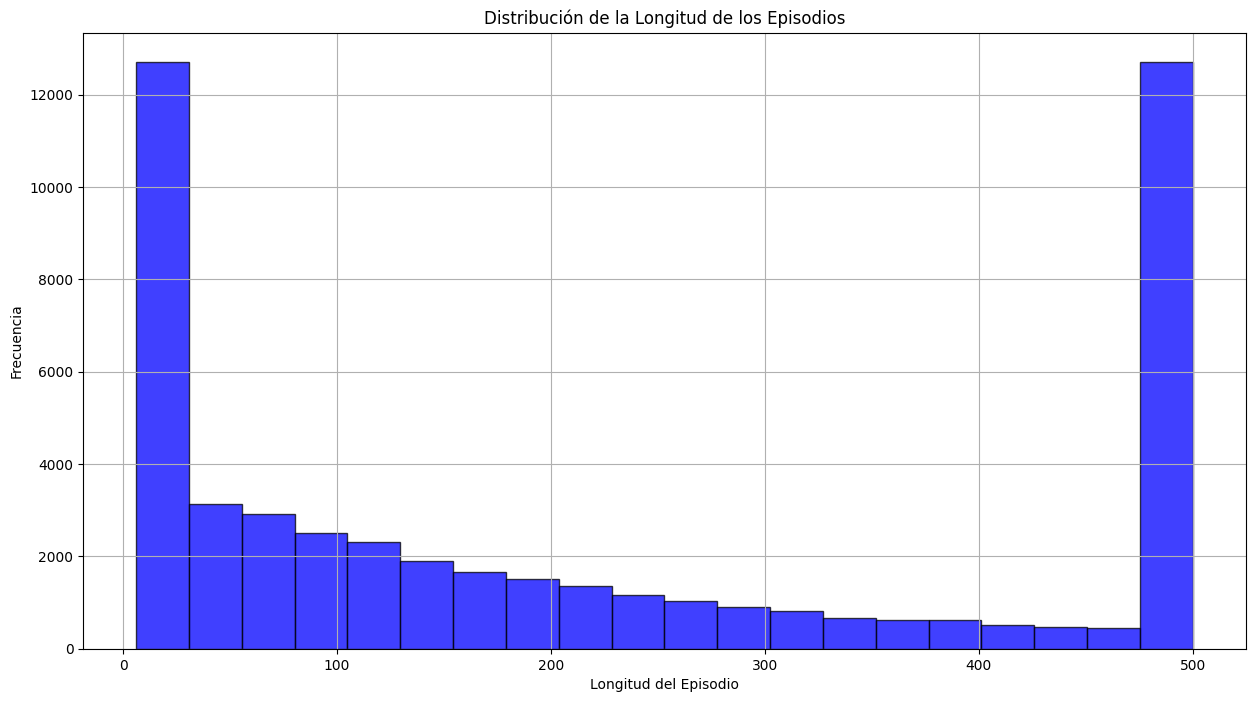

In [32]:
#@title Histograma con la longitud de los episodios

plot_episode_lengths_histogram(episode_lengths)

Al observar el histograma, vemos como muchos de los episodios alcanzan la longitud máxima permitida, no logrando llegar a un estado terminal. Esto puede estar dificultando el aprendizaje al agente.


Mostramos los valores Q para cada estado. Cada estado tienen 6 valores, que se corresponden con las 6 acciones que se pueden en cada estado.

In [33]:
# @title Tabla de valores Q
print("Valores Q para cada estado:\n", agent.Q)

Valores Q para cada estado:
 [[   0.            0.            0.            0.            0.
     0.        ]
 [-210.61404464 -101.91095465 -194.93361657 -176.3421646   -48.4576734
  -201.05090909]
 [-201.15448113 -195.30585002 -193.18585859 -139.97414515  -65.40408741
  -197.15182424]
 ...
 [-547.90076336  -19.8813987  -527.225      -594.23493976 -533.28834356
  -522.14880952]
 [-494.79473684 -458.48648649 -331.59621014 -524.38697318 -518.54359926
  -484.21880651]
 [-144.05194805 -179.3255814  -121.25842697   -2.75431862 -186.97619048
  -166.41071429]]


- También se muestra la política óptima (greedy) obtenida a partir del aprendizaje anterior.

- Cada estado tienen 4 valores, pero todos son 0 menos 1. Es decir, en cada estado se aplica de manera determinística una única acción.

*TODO:* Mostrar de forma gráfica el escenario.

In [34]:
# @title Política final
greedy_policy = GreedyFromQPolicy(env, agent.Q)
pi = greedy_policy.compute_policy_matrix()
states, actions = greedy_policy.new_episode()

print("Política óptima obtenida\n\n", pi, f"\n\n Acciones {actions} \n\n Para el siguiente grid\n", env.render())
print()

Política óptima obtenida

 [[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]] 

 Acciones [3, 1, 2, 4, 3, 3, 0, 0, 3, 3, 0, 0, 5] 

 Para el siguiente grid
 +---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)




In [35]:
# @title Simulaciones en vídeo
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

# Crear el entorno
render = "rgb_array"
env = gym.make("Taxi-v3", render_mode=render) # render_mode "rgb_array" es necesario para RecordVideo
env._max_episode_steps = 500  # Cambiar el límite de pasos

# Solo grabamos 2 episodios, por ejemplo
trigger = lambda episode_id: episode_id < 2  # Graba solo los primeros 10 episodios

# Aplica el wrapper RecordVideo para grabar vídeos
env = gym.wrappers.RecordVideo(
    env,
    video_folder=video_folder,
    episode_trigger=trigger,  # Graba solo los primeros 10 episodios
)

num_episodes = 2 # Número de episodios a grabar
#observation, info = env.reset(seed=42)
for episode in range(num_episodes):
    observation, info = env.reset(seed = seed)
    episode_over = False
    while not episode_over:

        # Renderiza el frame actual, esto lo guardará en el archivo de video.
        env.render()

        # El agente elige la acción usando la política entrenada
        action = agent.get_action(observation)

        # Ejecuta un paso en el entorno con la acción seleccionada.
        # Obtiene la siguiente observación, la recompensa,
        # y si el episodio ha terminado (terminated) o ha sido truncado (truncated).
        observation, reward, terminated, truncated, info = env.step(action)

        # Verifica si el episodio ha terminado, ya sea por terminación o truncamiento.
        episode_over = terminated or truncated


env.close() # Importante cerrar el entorno, ¡esto finaliza la grabación de vídeo!
print(f"Grabación de episodios completada. Vídeos guardados en la carpeta '{video_folder}'")

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated c

Grabación de episodios completada. Vídeos guardados en la carpeta 'videos'


In [36]:
latest_file = get_latest_episode_video_file(video_folder)
print(f"Último vídeo: {latest_file}") # outputs: ./video/rl-video-episode-4.mp4
embed_video(latest_file)

Último vídeo: videos/rl-video-episode-1.mp4


A pesar de las dificultades en el entrenamiento, el agente consigue recoger un pasajero y llevarlo a la zona de destino. Por lo tanto, el agente ha conseguido aprender, aunque su funcionamiento es claramente mejorable.

## **5. Monte Carlo off-policy**

   - En esta sección, el algoritmo de Monte Carlo off-policy con la política epsilon-soft se ejecuta para el entorno Taxi, con las recompensas modificadas, similar a como hemos hecho en el apartado anterior.
   
   - En ambos casos se realiza un entrenamiento con un número determinado de episodios (50000 en concreto)

   - Además el epsilon tiene decaimiento de acuerdo a la expresión: $\epsilon = min(1.0, 1000.0/(t+1))$

   - Durante el entrenamiento hay una visualización de la proporción de recompensas obtenidas a lo largo del entrenamiento.

   - Junto a dicho volcado se muestra gráficamente la proporción de recompensas obtenidas.

   - También se hace un volcado de los valores Q de cada estado, donde se muestra cómo el agente valora diferentes acciones en distintos estados del entorno, lo que puede interpretarse como su conocimiento sobre las mejores estrategias para alcanzar la meta sin caer en los agujeros.

   - Además, se muestra la política óptima derivada de los valores Q. Esta política es la que el agente seguiría si tuviera que elegir siempre la acción que maximiza su recompensa esperada.

   

In [37]:
#@title Importamos el entorno
name = 'Taxi-v3'
env = gym.make(name, render_mode="ansi")
env.reset(seed=seed)

(333, {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)})

In [38]:
#@title **Modificación del límite de pasos**

env._max_episode_steps = 500  # Cambiar el límite de pasos

In [39]:
# @title **Aprendizaje**
agent = AgentMCOffPolicyAllVisits(env, epsilon=1, decay=True, discount_factor=0.9)
agent.train(num_episodes=50000)

# Estadísticos
list_stats, episode_lengths = agent.get_stats()

 10%|█         | 5015/50000 [01:29<08:04, 92.93it/s]

success: 1.8939411420876506, epsilon: 0.19996000799840033


 20%|██        | 10011/50000 [02:27<07:10, 92.96it/s]

success: 2.631245529989174, epsilon: 0.0999900009999


 30%|███       | 15009/50000 [03:33<08:00, 72.90it/s]

success: 2.36243660461356, epsilon: 0.06666222251849876


 40%|████      | 20008/50000 [04:43<07:23, 67.56it/s]

success: 1.992692954114729, epsilon: 0.04999750012499375


 50%|█████     | 25012/50000 [06:01<05:39, 73.70it/s]

success: 1.6372192336564828, epsilon: 0.03999840006399744


 60%|██████    | 30012/50000 [07:20<05:07, 64.93it/s]

success: 1.3400246071126367, epsilon: 0.033332222259258026


 70%|███████   | 35013/50000 [08:43<03:47, 66.00it/s]

success: 1.1236148407792423, epsilon: 0.02857061226822091


 80%|████████  | 40008/50000 [10:10<02:56, 56.55it/s]

success: 0.9288467322844448, epsilon: 0.02499937501562461


 90%|█████████ | 45009/50000 [11:41<01:48, 46.12it/s]

success: 0.7573853693596403, epsilon: 0.02222172840603542


100%|██████████| 50000/50000 [13:09<00:00, 63.34it/s]


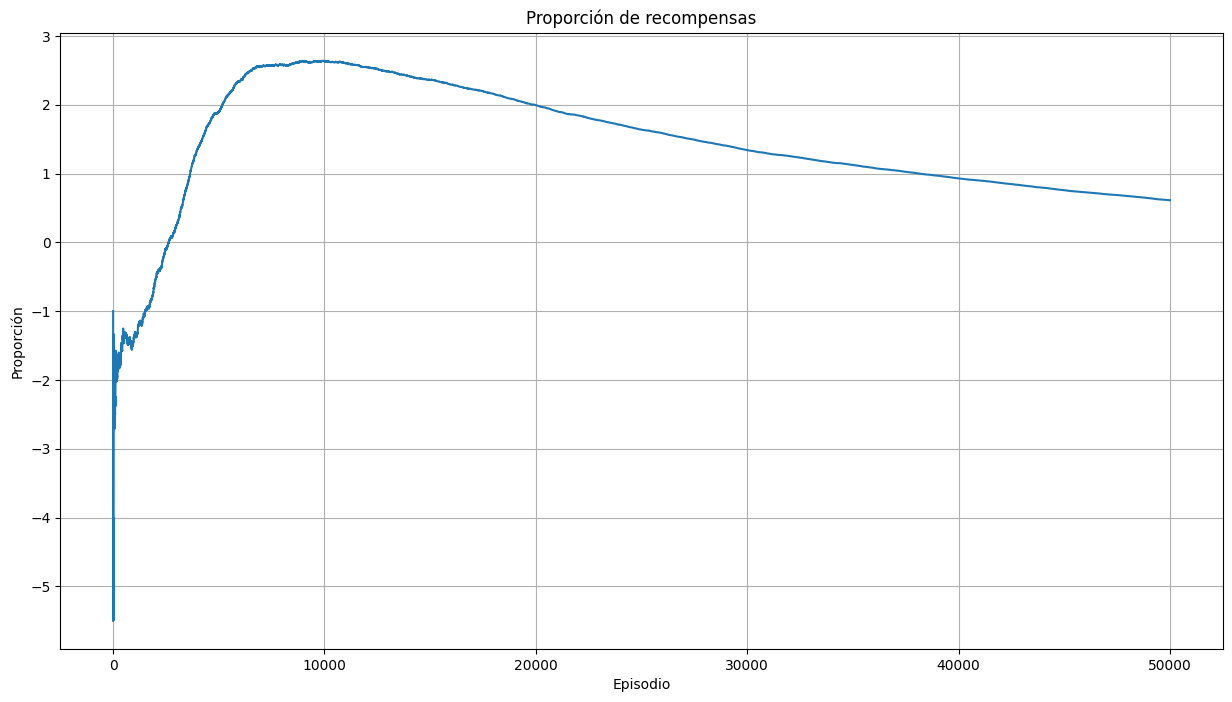

Máxima proporcion: 0.612101870876775


In [40]:
#@title **Proporción de aciertos por número de episodios**

plot(list_stats)
print(f"Máxima proporcion: {list_stats[-1]}")

Observando la gráfica para la proporción de recompensas con Monte Carlo off-policy, esta claramente mejora con respecto a Monte Carlo on-policy, pues en este caso se logran alcanzar recompensas positivas, indicando que la estrategia de usar dos políticas, una política objetivo y una de comportamiento, ayuda a mejorar el rendimiento del algoritmo.

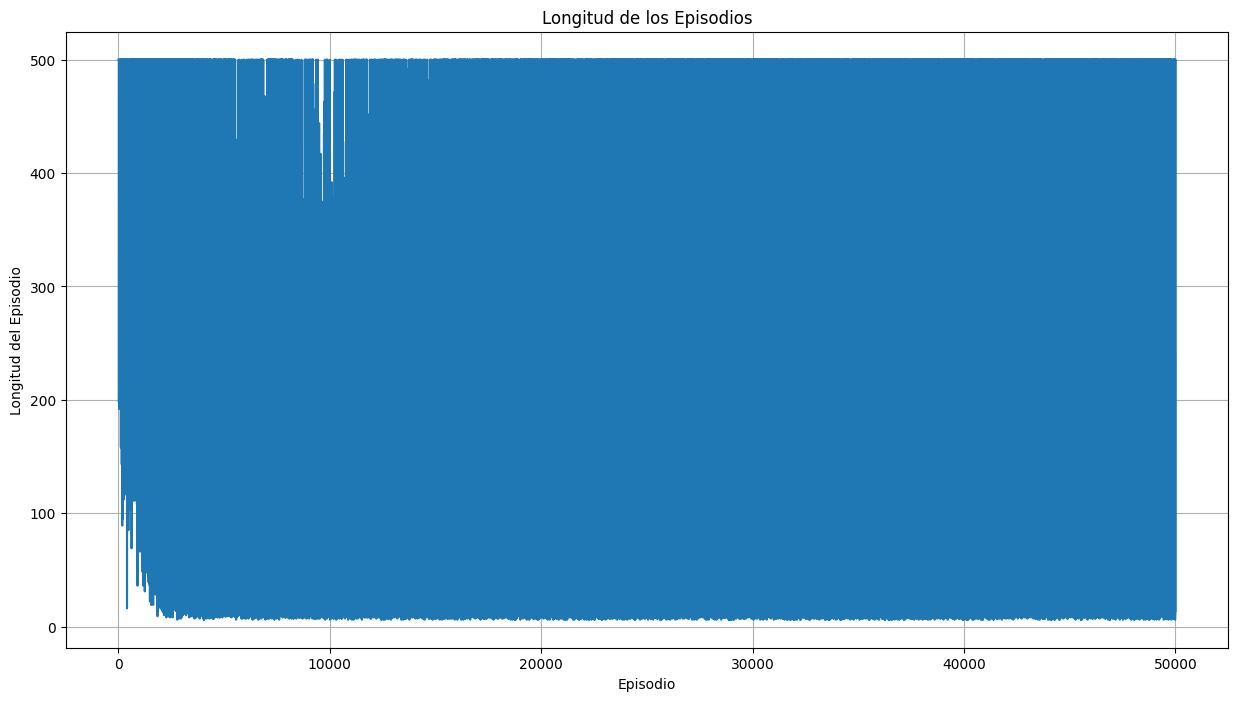

In [41]:
#@title **Longitud de los episodios**

plot_episode_lengths(episode_lengths)

La longitud máxima permitida para los episodios sigue siendo algo baja, pues con el paso de los episodios, la longitud de los mismos no consigue disminuir. En muchos episodios se alcanza el máximo permitido sin llegar a un estado terminal.

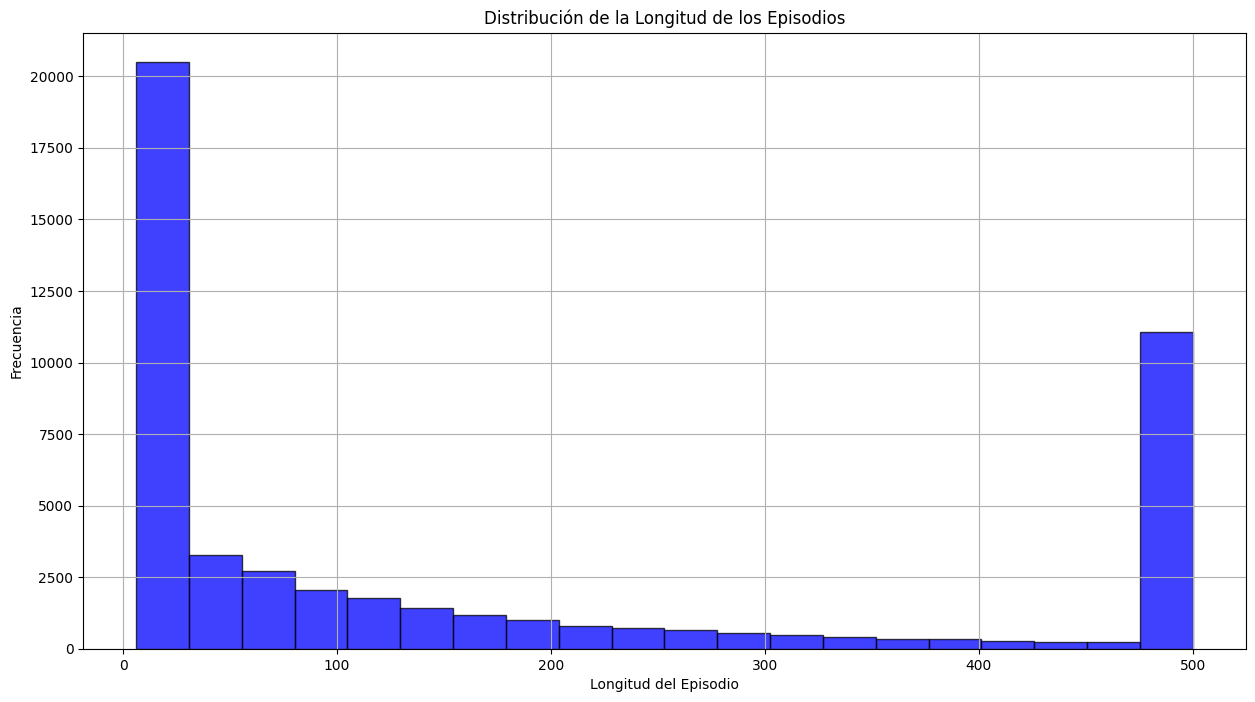

In [42]:
#@title **Histograma con la longitud de los episodios**

plot_episode_lengths_histogram(episode_lengths)

No obstante, al observar el histograma, vemos que en realidad en la mayoría de episodios sí se está consiguiendo llegar a un estado terminal, pues se está resolviendo el juego en pocos pasos.

In [43]:
# @title **Tabla de valores Q**
print("Valores Q para cada estado:\n", agent.Q)

Valores Q para cada estado:
 [[  0.           0.           0.           0.           0.
    0.        ]
 [ -0.64617707   0.4603532   -0.58568212   0.4603532    1.62074125
   -8.5396468 ]
 [  2.24741082   5.78350381   4.348907     5.83734597   7.71024721
   -3.05677   ]
 ...
 [  6.82604309   9.683        7.7147       5.94323     -1.2853
   -1.2853    ]
 [ -1.           2.9140163   -1.           0.          -7.37738533
  -10.        ]
 [ 14.3         11.87        14.3         17.           5.3
    5.3       ]]


In [44]:
# @title **Política final**
greedy_policy = GreedyFromQPolicy(env, agent.Q)
pi = greedy_policy.compute_policy_matrix()
states, actions = greedy_policy.new_episode()

print("Política óptima obtenida\n\n", pi, f"\n\n Acciones {actions} \n\n Para el siguiente grid\n", env.render())
print()

Política óptima obtenida

 [[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]] 

 Acciones [1, 4, 0, 0, 2, 2, 1, 2, 2, 1, 5] 

 Para el siguiente grid
 +---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)




In [45]:
# @title Simulaciones en vídeo
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

# Crear el entorno
render = "rgb_array"
env = gym.make("Taxi-v3", render_mode=render) # render_mode "rgb_array" es necesario para RecordVideo
env._max_episode_steps = 500  # Cambiar el límite de pasos

# Solo grabamos 2 episodios, por ejemplo
trigger = lambda episode_id: episode_id < 2  # Graba solo los primeros 10 episodios

# Aplica el wrapper RecordVideo para grabar vídeos
env = gym.wrappers.RecordVideo(
    env,
    video_folder=video_folder,
    episode_trigger=trigger,  # Graba solo los primeros 10 episodios
)

num_episodes = 2 # Número de episodios a grabar
#observation, info = env.reset(seed=42)
for episode in range(num_episodes):
    observation, info = env.reset(seed = seed)
    episode_over = False
    while not episode_over:

        # Renderiza el frame actual, esto lo guardará en el archivo de video.
        env.render()

        # El agente elige la acción usando la política entrenada
        action = agent.get_greedy_action(observation)

        # Ejecuta un paso en el entorno con la acción seleccionada.
        # Obtiene la siguiente observación, la recompensa,
        # y si el episodio ha terminado (terminated) o ha sido truncado (truncated).
        observation, reward, terminated, truncated, info = env.step(action)

        # Verifica si el episodio ha terminado, ya sea por terminación o truncamiento.
        episode_over = terminated or truncated


env.close() # Importante cerrar el entorno, ¡esto finaliza la grabación de vídeo!
print(f"Grabación de episodios completada. Vídeos guardados en la carpeta '{video_folder}'")

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Grabación de episodios completada. Vídeos guardados en la carpeta 'videos'


In [46]:
latest_file = get_latest_episode_video_file(video_folder)
print(f"Último vídeo: {latest_file}") # outputs: ./video/rl-video-episode-4.mp4
embed_video(latest_file)

Último vídeo: videos/rl-video-episode-1.mp4


En la simulación del vídeo se consigue encontrar un camino óptimo hasta la meta. Alcanza la meta en 14 pasos.

## **6. SARSA**

   - En esta sección, el algoritmo de SARSA con la política epsilon-soft se ejecuta para el entorno Taxi, con las recompensas ya modificadas en el apartado anterior.
   
   - En ambos casos se realiza un entrenamiento con un número determinado de episodios (50000 en concreto)

   - Además el epsilon tiene decaimiento de acuerdo a la expresión: $\epsilon = min(1.0, 1000.0/(t+1))$

   - Durante el entrenamiento hay una visualización de la proporción de recompensas obtenidas a lo largo del entrenamiento.

   - Junto a dicho volcado se muestra gráficamente la proporción de recompensas obtenidas.

   - También se hace un volcado de los valores Q de cada estado, donde se muestra cómo el agente valora diferentes acciones en distintos estados del entorno, lo que puede interpretarse como su conocimiento sobre las mejores estrategias para alcanzar la meta sin caer en los agujeros.

   - Además, se muestra la política óptima derivada de los valores Q. Esta política es la que el agente seguiría si tuviera que elegir siempre la acción que maximiza su recompensa esperada.

   

In [47]:
#@title Importamos el entorno
name = 'Taxi-v3'
env = gym.make(name, render_mode="ansi")
env.reset(seed=seed)

(333, {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)})

In [48]:
#@title **Modificación del límite de pasos**

env._max_episode_steps = 500  # Cambiar el límite de pasos

In [49]:
# @title **Aprendizaje**
agent = AgentSARSA(env, epsilon=1, decay=True, discount_factor=0.9, alpha=0.7)
agent.train(num_episodes=50000)

# Estadísticos
list_stats, episode_lengths = agent.get_stats()

 10%|█         | 5044/50000 [00:59<02:07, 352.71it/s]

success: -686.0108, epsilon: 0.19996000799840033


 20%|██        | 10037/50000 [01:14<02:47, 238.89it/s]

success: -370.2977, epsilon: 0.0999900009999


 30%|███       | 15038/50000 [01:24<01:25, 409.50it/s]

success: -256.05173333333335, epsilon: 0.06666222251849876


 40%|████      | 20136/50000 [01:35<00:42, 700.64it/s]

success: -196.9282, epsilon: 0.04999750012499375


 50%|█████     | 25115/50000 [01:43<00:27, 888.94it/s]

success: -158.85884, epsilon: 0.03999840006399744


 60%|██████    | 30195/50000 [01:51<00:20, 961.65it/s]

success: -134.1372, epsilon: 0.033332222259258026


 70%|███████   | 35149/50000 [01:57<00:15, 946.64it/s]

success: -115.63911428571429, epsilon: 0.02857061226822091


 80%|████████  | 40166/50000 [02:03<00:09, 1060.39it/s]

success: -101.27425, epsilon: 0.02499937501562461


 90%|█████████ | 45149/50000 [02:09<00:05, 929.38it/s]

success: -90.35806666666667, epsilon: 0.02222172840603542


100%|██████████| 50000/50000 [02:16<00:00, 367.61it/s]


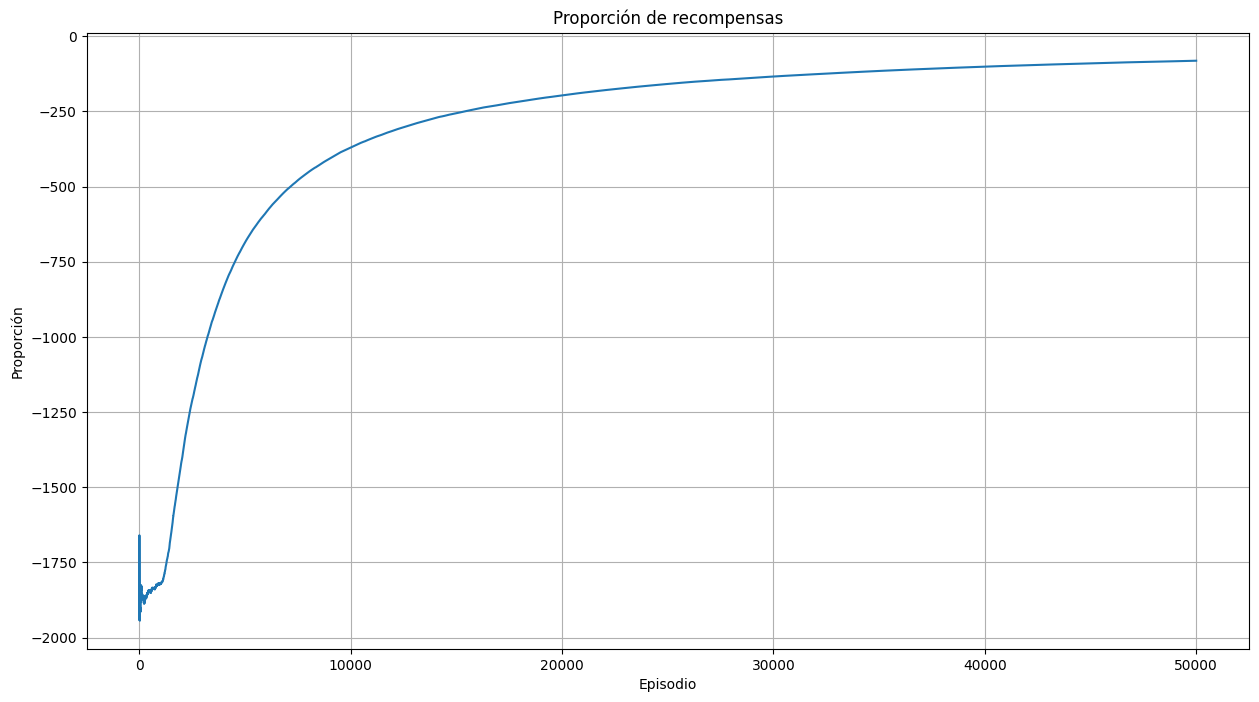

Máxima proporcion: -81.64964


In [50]:
#@title **Proporción de aciertos por número de episodios**

plot(list_stats)
print(f"Máxima proporcion: {list_stats[-1]}")

En este caso vemos que la proporción de recompensas aumenta, por lo que el agente está aprendiendo, pero no logra alcanzar valores positivos para dicha proporción. Esto quiere decir que en la mayoría de episodios no está alcanzando la meta.

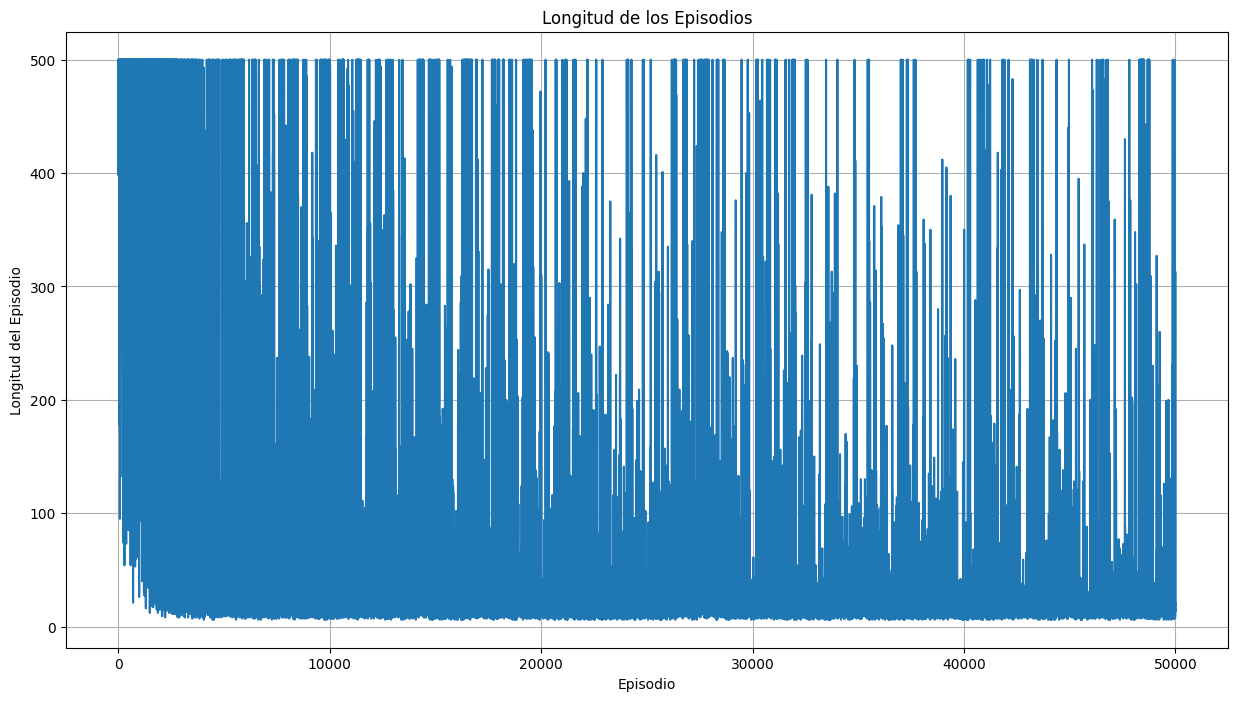

In [51]:
#@title **Longitud de los episodios**

plot_episode_lengths(episode_lengths)

Al observar la gráfica con el número de pasos por episodio, descubrimos donde está el problema: el límite de pasos de 1000 es demasiado bajo, pues la mayoría de episodios no consiguen llegar a ningún estado terminal en 1000 pasos. Por esta razón, el agente no está consiguiendo aprender correctamente un camino óptimo hasta la meta.

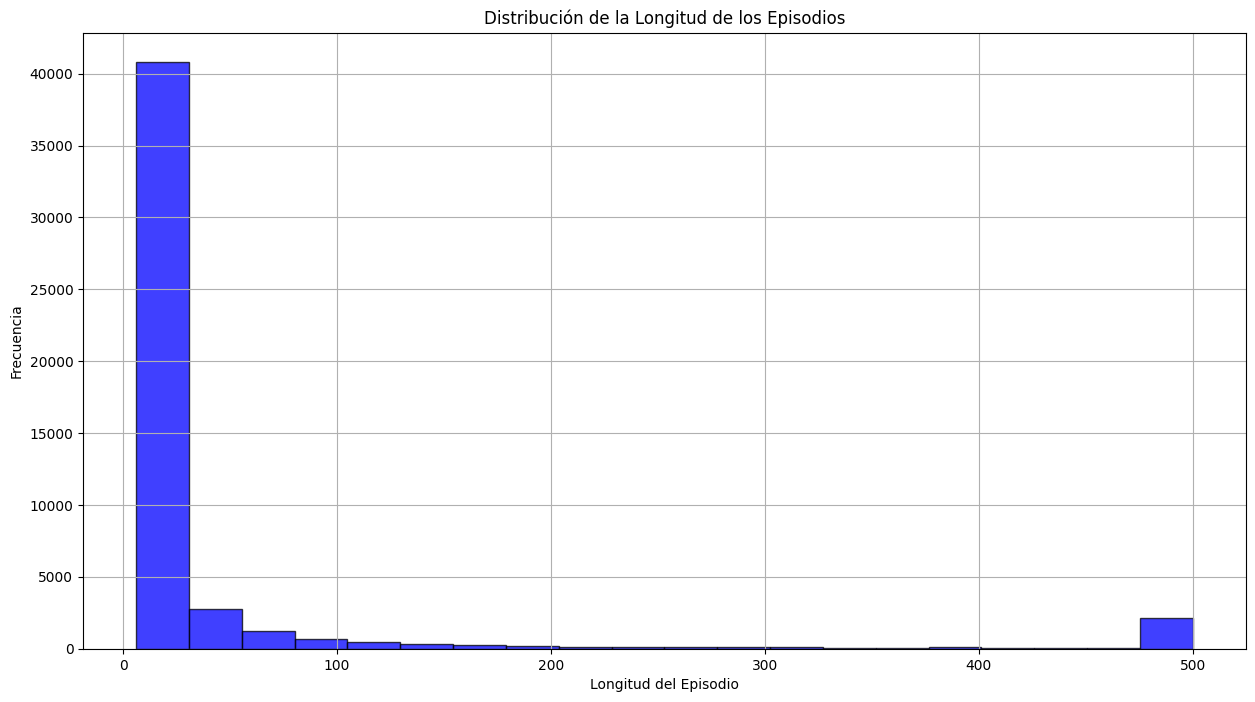

In [52]:
#@title **Histograma con la longitud de los episodios**

plot_episode_lengths_histogram(episode_lengths)

Esto mismo se aprecia claramente en el gráfico con la distribución de la longitud de los episodios, donde se observa que la mayoría de ellos tienen una longitud de 1000, pues no llegan a ningún estado terminal.

In [53]:
# @title **Tabla de valores Q**
print("Valores Q para cada estado:\n", agent.Q)

Valores Q para cada estado:
 [[  0.           0.           0.           0.           0.
    0.        ]
 [ -6.0538232   -6.182793    -7.53136745  -6.55559805   0.54735169
  -10.13444067]
 [ -0.56705168  -0.55998245   0.07322531  -0.37095434   7.08520136
   -3.86218603]
 ...
 [ -0.52178407   2.61061005  -6.80145624   1.11273736  -9.01248923
   -3.92108057]
 [-13.14497631 -10.65268948  -6.212983     1.18430294 -11.97287782
  -15.51973551]
 [ 12.08658104   7.80322113  12.320076    17.           5.29862385
    5.29400168]]


In [54]:
# @title **Política final**
greedy_policy = GreedyFromQPolicy(env, agent.Q)
pi = greedy_policy.compute_policy_matrix()
states, actions = greedy_policy.new_episode()

print("Política óptima obtenida\n\n", pi, f"\n\n Acciones {actions} \n\n Para el siguiente grid\n", env.render())
print()

Política óptima obtenida

 [[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]] 

 Acciones [1, 1, 1, 4, 0, 2, 0, 2, 2, 2, 1, 1, 5] 

 Para el siguiente grid
 +---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)




In [55]:
# @title Simulaciones en vídeo
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

# Crear el entorno
render = "rgb_array"
env = gym.make("Taxi-v3", render_mode=render) # render_mode "rgb_array" es necesario para RecordVideo
env._max_episode_steps = 500  # Cambiar el límite de pasos

# Solo grabamos 2 episodios, por ejemplo
trigger = lambda episode_id: episode_id < 2  # Graba solo los primeros 2 episodios

# Aplica el wrapper RecordVideo para grabar vídeos
env = gym.wrappers.RecordVideo(
    env,
    video_folder=video_folder,
    episode_trigger=trigger,  # Graba solo los primeros 10 episodios
)

num_episodes = 2 # Número de episodios a grabar
#observation, info = env.reset(seed=42)
for episode in range(num_episodes):
    observation, info = env.reset(seed = seed)
    episode_over = False
    while not episode_over:

        # Renderiza el frame actual, esto lo guardará en el archivo de video.
        env.render()

        # El agente elige la acción usando la política entrenada
        action = agent.get_action(observation)

        # Ejecuta un paso en el entorno con la acción seleccionada.
        # Obtiene la siguiente observación, la recompensa,
        # y si el episodio ha terminado (terminated) o ha sido truncado (truncated).
        observation, reward, terminated, truncated, info = env.step(action)

        # Verifica si el episodio ha terminado, ya sea por terminación o truncamiento.
        episode_over = terminated or truncated


env.close() # Importante cerrar el entorno, ¡esto finaliza la grabación de vídeo!
print(f"Grabación de episodios completada. Vídeos guardados en la carpeta '{video_folder}'")

Grabación de episodios completada. Vídeos guardados en la carpeta 'videos'


In [56]:
latest_file = get_latest_episode_video_file(video_folder)
print(f"Último vídeo: {latest_file}") # outputs: ./video/rl-video-episode-4.mp4
embed_video(latest_file)

Último vídeo: videos/rl-video-episode-1.mp4


En el vídeo se observa como el personaje no logra alcanzar la meta, y además pasa un tiempo considerable dando vueltas por el mapa hasta que finalmente cae por un agujero. La razón es que el número de pasos máximo usado en el entrenamiento era demasiado bajo para que SARSA lograra aprender el camino hasta la meta.

## **7. Q-Learning**

   - En esta sección, el algoritmo de Q-Learning con la política epsilon-soft se ejecuta para el entorno de 8x8 de FrozenLake sin resbalar, con las recompensas ya modificadas en el apartado anterior.
   
   - En ambos casos se realiza un entrenamiento con un número determinado de episodios (50000 en concreto)

   - Además el epsilon tiene decaimiento de acuerdo a la expresión: $\epsilon = min(1.0, 1000.0/(t+1))$

   - Durante el entrenamiento hay una visualización de la proporción de recompensas obtenidas a lo largo del entrenamiento.

   - Junto a dicho volcado se muestra gráficamente la proporción de recompensas obtenidas.

   - También se hace un volcado de los valores Q de cada estado, donde se muestra cómo el agente valora diferentes acciones en distintos estados del entorno, lo que puede interpretarse como su conocimiento sobre las mejores estrategias para alcanzar la meta sin caer en los agujeros.

   - Además, se muestra la política óptima derivada de los valores Q. Esta política es la que el agente seguiría si tuviera que elegir siempre la acción que maximiza su recompensa esperada.

   

In [57]:
#@title Importamos el entorno
name = 'Taxi-v3'
env = gym.make(name, render_mode="ansi")
env.reset(seed=seed)

(333, {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)})

In [58]:
#@title **Modificación del límite de pasos**

env._max_episode_steps = 500  # Cambiar el límite de pasos

In [59]:
# @title **Aprendizaje**
agent = AgentQLearning(env, epsilon=1, decay=True, discount_factor=0.9, alpha=0.7)
agent.train(num_episodes=50000)

# Estadísticos
list_stats, episode_lengths = agent.get_stats()

 10%|█         | 5159/50000 [00:38<00:51, 869.58it/s]

success: -425.2392, epsilon: 0.19996000799840033


 20%|██        | 10221/50000 [00:43<00:38, 1032.09it/s]

success: -212.8926, epsilon: 0.0999900009999


 30%|███       | 15090/50000 [00:49<01:04, 537.68it/s]

success: -140.74533333333332, epsilon: 0.06666222251849876


 40%|████      | 20212/50000 [00:54<00:28, 1040.17it/s]

success: -104.3228, epsilon: 0.04999750012499375


 50%|█████     | 25149/50000 [00:59<00:23, 1044.67it/s]

success: -82.35884, epsilon: 0.03999840006399744


 60%|██████    | 30213/50000 [01:04<00:21, 933.20it/s]

success: -67.61556666666667, epsilon: 0.033332222259258026


 70%|███████   | 35160/50000 [01:09<00:13, 1104.70it/s]

success: -57.02554285714286, epsilon: 0.02857061226822091


 80%|████████  | 40187/50000 [01:14<00:08, 1120.20it/s]

success: -49.0807, epsilon: 0.02499937501562461


 90%|█████████ | 45167/50000 [01:18<00:04, 1002.25it/s]

success: -42.87882222222222, epsilon: 0.02222172840603542


100%|██████████| 50000/50000 [01:24<00:00, 593.97it/s] 


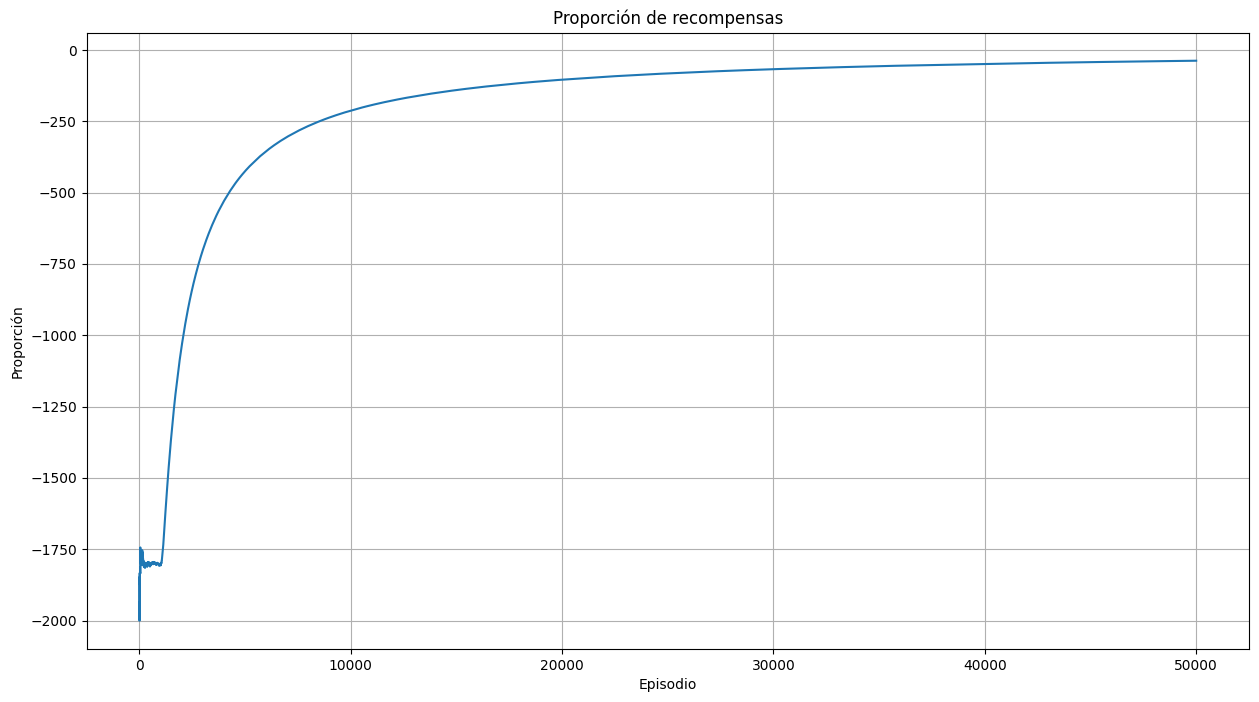

Máxima proporcion: -37.91076


In [60]:
#@title **Proporción de aciertos por número de episodios**

plot(list_stats)
print(f"Máxima proporcion: {list_stats[-1]}")

El algoritmo Q-learning da buenos resultados, como se observa en el gráfico de la proporción de recompensas. Al principio, como suele ocurrir, dicha proporción es muy baja y negativa, pero con el paso de los episodios, rápidamente empieza a aumentar hasta alcanzar un máximo de $66.77$. Este valor es bastante elevado y muestra que el agente está logrando aprender un buen camino hasta la meta.

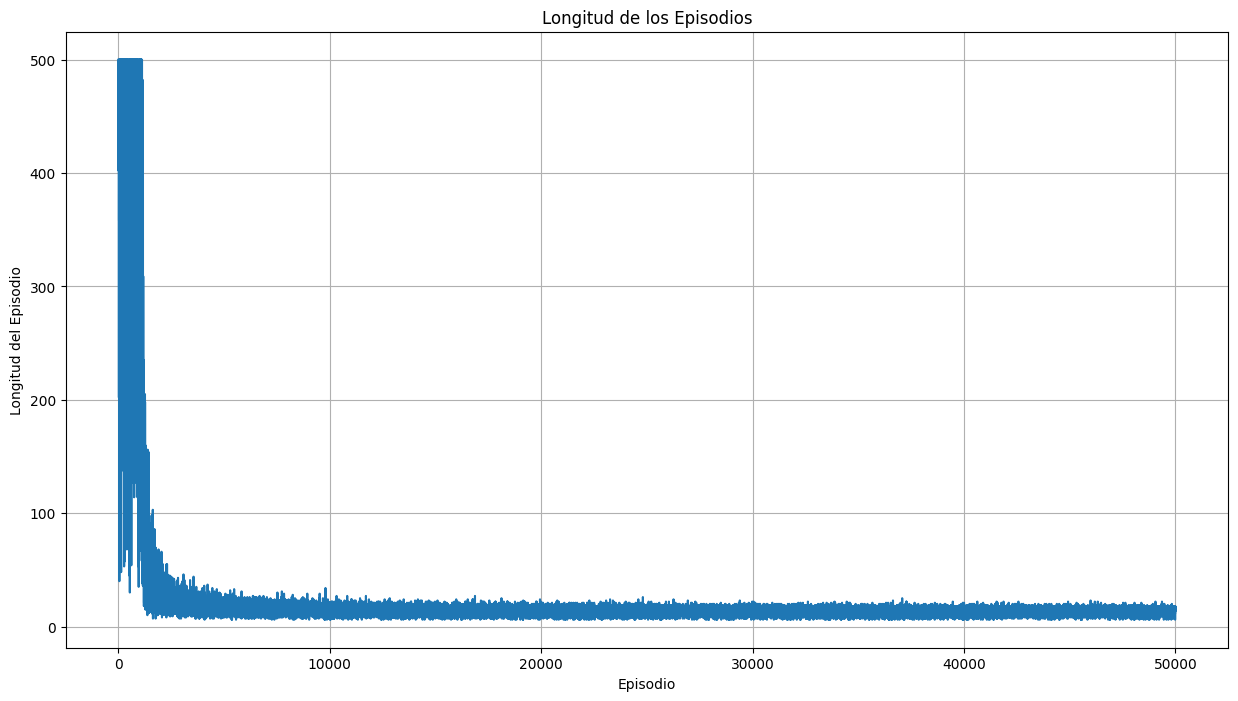

In [61]:
#@title **Longitud de los episodios**

plot_episode_lengths(episode_lengths)

La longitud de los episodios comienza siendo algo más elevada, pero rápidamente disminuye y se estabiliza en valores bastante bajos, lo que junto con la anterior gráfica muestra que el agente está logrando encontrar un camino hasta la meta, y además encuentra un camino óptimo.

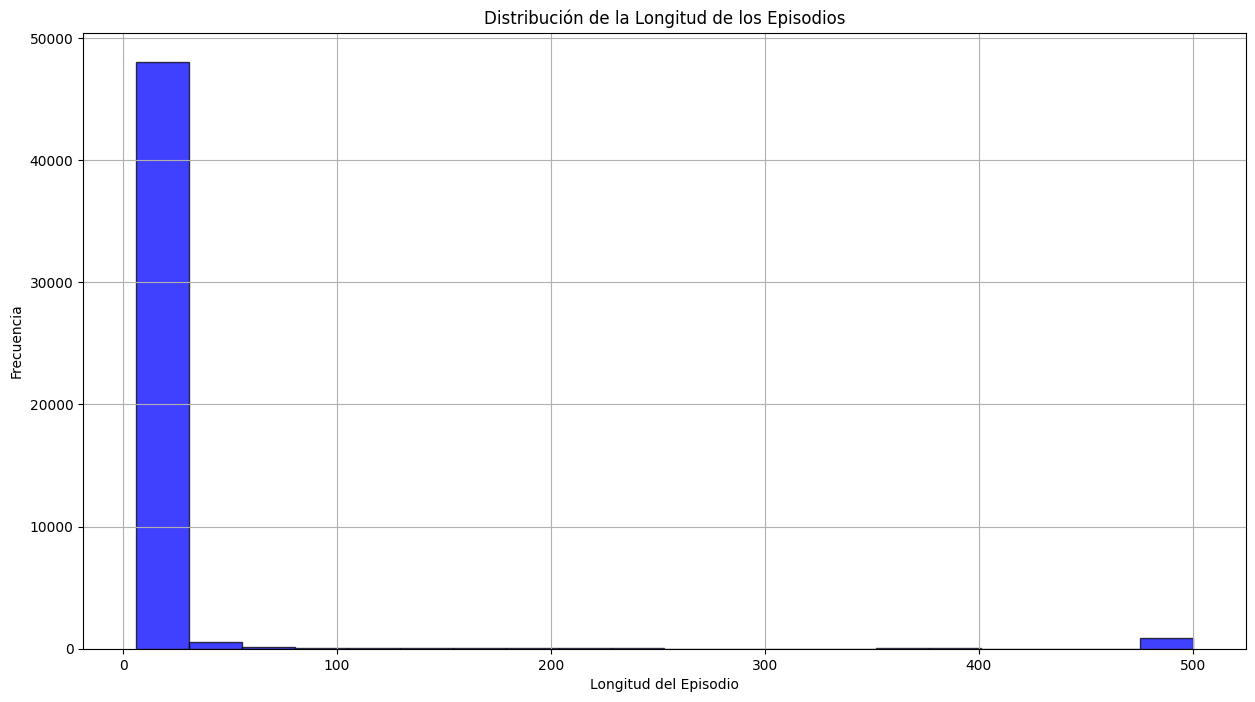

In [62]:
#@title **Histograma con la longitud de los episodios**

plot_episode_lengths_histogram(episode_lengths)

Mirando la longitud de los episodios, vemos como todos son bastante bajos, y ninguno alcanza los 1000 pasos, que es el máximo permitido. Esto puede deberse a que en los primeros episodios, el algoritmo rápidamente llega a un estado terminal, probablemente un agujero, aunque con el paso de los episodios consigue corregir su camino para favorecer uno que llegue hasta la meta.

In [63]:
# @title **Tabla de valores Q**
print("Valores Q para cada estado:\n", agent.Q)

Valores Q para cada estado:
 [[ 0.          0.          0.          0.          0.          0.        ]
 [-0.58568212  0.4603532  -0.58568212  0.4603532   1.62261467 -8.5396468 ]
 [ 4.348907    5.94323     4.348907    5.94323     7.7147     -3.05677   ]
 ...
 [ 7.7147      9.683       7.7147      5.94323    -1.2853     -1.2853    ]
 [ 1.62261467  2.9140163   1.62261467  2.9140163  -7.37738533 -7.37738533]
 [14.3        11.87       14.3        17.          5.3         5.3       ]]


In [64]:
# @title **Política final**
greedy_policy = GreedyFromQPolicy(env, agent.Q)
pi = greedy_policy.compute_policy_matrix()
states, actions = greedy_policy.new_episode()

print("Política óptima obtenida\n\n", pi, f"\n\n Acciones {actions} \n\n Para el siguiente grid\n", env.render())
print()

Política óptima obtenida

 [[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]] 

 Acciones [1, 4, 0, 0, 3, 3, 3, 3, 0, 0, 5] 

 Para el siguiente grid
 +---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)




In [65]:
# @title Simulaciones en vídeo
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

# Crear el entorno
render = "rgb_array"
env = gym.make("Taxi-v3", render_mode=render) # render_mode "rgb_array" es necesario para RecordVideo
env._max_episode_steps = 500  # Cambiar el límite de pasos

# Solo grabamos 10 episodios, por ejemplo
trigger = lambda episode_id: episode_id < 10  # Graba solo los primeros 10 episodios

# Aplica el wrapper RecordVideo para grabar vídeos
env = gym.wrappers.RecordVideo(
    env,
    video_folder=video_folder,
    episode_trigger=trigger,  # Graba solo los primeros 10 episodios
)

num_episodes = 10 # Número de episodios a grabar
#observation, info = env.reset(seed=42)
for episode in range(num_episodes):
    observation, info = env.reset(seed = seed)
    episode_over = False
    while not episode_over:

        # Renderiza el frame actual, esto lo guardará en el archivo de video.
        env.render()

        # El agente elige la acción usando la política entrenada
        action = agent.get_action(observation)

        # Ejecuta un paso en el entorno con la acción seleccionada.
        # Obtiene la siguiente observación, la recompensa,
        # y si el episodio ha terminado (terminated) o ha sido truncado (truncated).
        observation, reward, terminated, truncated, info = env.step(action)

        # Verifica si el episodio ha terminado, ya sea por terminación o truncamiento.
        episode_over = terminated or truncated


env.close() # Importante cerrar el entorno, ¡esto finaliza la grabación de vídeo!
print(f"Grabación de episodios completada. Vídeos guardados en la carpeta '{video_folder}'")

Grabación de episodios completada. Vídeos guardados en la carpeta 'videos'


In [66]:
latest_file = get_latest_episode_video_file(video_folder)
print(f"Último vídeo: {latest_file}") # outputs: ./video/rl-video-episode-4.mp4
embed_video(latest_file)

Último vídeo: videos/rl-video-episode-9.mp4


Finalmente, en esta simulación el personaje alcanza la meta en 14 pasos, por lo que gracias a Q-learning se ha conseguido aprender un camino óptimo.